# **Preprocessing**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# 1. Environment Setup

In [ ]:
import os
import glob
import gc
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define paths
dataset_path = "/content/drive/MyDrive/CIC-IDS-2017/GeneratedLabelledFlows/TrafficLabelling_/"
intermediate_path = "/content/drive/MyDrive/CIC-IDS-2017/processed_cic_ids_2017.csv"
encoded_path = "/content/drive/MyDrive/CIC-IDS-2017/processed_encoded.csv"
final_path = "/content/drive/MyDrive/CIC-IDS-2017/final_cgan_ready_scaled.csv"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2. Load & Concatenate Raw CSV Files



In [ ]:
csv_files = glob.glob(os.path.join(dataset_path, "*.csv"))
df = pd.concat([pd.read_csv(f, low_memory=True, encoding='latin-1') for f in csv_files], ignore_index=True)
df.columns = df.columns.str.strip()

# Drop unnecessary metadata columns
drop_cols = ["Flow ID", "Source IP", "Destination IP", "Timestamp"]
df.drop(columns=[col for col in drop_cols if col in df.columns], inplace=True, errors='ignore')

<ipython-input-16-ebed5d1919b0>:2: DtypeWarning: Columns (0,1,3,6,84) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.concat([pd.read_csv(f, low_memory=True, encoding='latin-1') for f in csv_files], ignore_index=True)


In [ ]:
print("Label Value Counts:")
print(df["Label"].value_counts())

Label Value Counts:
Label
BENIGN                        2273097
DoS Hulk                       231073
PortScan                       158930
DDoS                           128027
DoS GoldenEye                   10293
FTP-Patator                      7938
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1966
Web Attack  Brute Force         1507
Web Attack  XSS                  652
Infiltration                       36
Web Attack  Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64


# 3. Filter & Clean Labels

In [ ]:
selected_labels = ["BENIGN", "DoS Hulk", "PortScan", "DDoS", "FTP-Patator"]
label_map = {
    "BENIGN": 0,
    "DoS Hulk": 1,
    "PortScan": 2,
    "DDoS": 3,
    "FTP-Patator": 4
}
df = df[df["Label"].isin(selected_labels)].copy()
df["Label"] = df["Label"].astype(str).str.strip().map(label_map)

# Drop NaNs / Infinite to Prevent Imbalance
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [ ]:
print("Label Value Counts:")
print(df["Label"].value_counts())
"Protocol" in df.columns

Label Value Counts:
Label
0    2271320
1     230124
2     158804
3     128025
4       7935
Name: count, dtype: int64


True

# 4. Downsample to Balance Classes

In [ ]:
min_size = df["Label"].value_counts().min()
df_balanced = pd.concat([
    resample(df[df["Label"] == label], replace=False, n_samples=min_size, random_state=42)
    for label in label_map.values()
]).sample(frac=1, random_state=42).reset_index(drop=True)

# Save balanced version
df_balanced.to_csv(intermediate_path, index=False)

In [ ]:
print("✅ Downsampled Class Distribution:")
print(df_balanced["Label"].value_counts())

✅ Downsampled Class Distribution:
Label
1    7935
4    7935
0    7935
2    7935
3    7935
Name: count, dtype: int64


# 5. Chunked One-Hot Encoding (Protocol feature)

In [ ]:
chunk_size = 500000
if os.path.exists(encoded_path):
    os.remove(encoded_path)

reader = pd.read_csv(intermediate_path, chunksize=chunk_size, encoding='latin-1')

for i, chunk in enumerate(reader):
    chunk.columns = chunk.columns.str.strip()
    if "Protocol" in chunk.columns:
        chunk = pd.get_dummies(chunk, columns=["Protocol"], prefix="Proto")
    chunk.to_csv(encoded_path, index=False if i == 0 else False, header=(i == 0), mode='a')
    del chunk
    gc.collect()

# 6. Final Cleanup & Label Encoding

In [ ]:
df = pd.read_csv(encoded_path)

# Drop constant columns (zero variance)
zero_var_cols = [col for col in df.columns if df[col].nunique() <= 1]
df.drop(columns=zero_var_cols, inplace=True)

# Drop any new NaNs or infinite
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

# 7. Drop Zero-Variance Columns

In [ ]:
# === 8. Scale Features to [0, 1] ===
feature_cols = df.columns[df.columns != "Label"]
scaler = MinMaxScaler()
df[feature_cols] = scaler.fit_transform(df[feature_cols])

# Save Final Scaled Dataset
df.to_csv(final_path, index=False)
print("📁 Final CGAN-ready dataset saved:", final_path)

📁 Final CGAN-ready dataset saved: /content/drive/MyDrive/CIC-IDS-2017/final_cgan_ready_scaled.csv


# 8. Verification

In [ ]:
print("🔍 Final shape:", df.shape)
print("📊 Final label distribution:\n", df["Label"].value_counts())
print("🧪 Feature min:", df[feature_cols].min().min())
print("🧪 Feature max:", df[feature_cols].max().max())

🔍 Final shape: (39675, 75)
📊 Final label distribution:
 Label
1    7935
4    7935
0    7935
2    7935
3    7935
Name: count, dtype: int64
🧪 Feature min: 0.0
🧪 Feature max: 1.0000000000000002


**8.1 PCA evaluation of preprocessesd data**

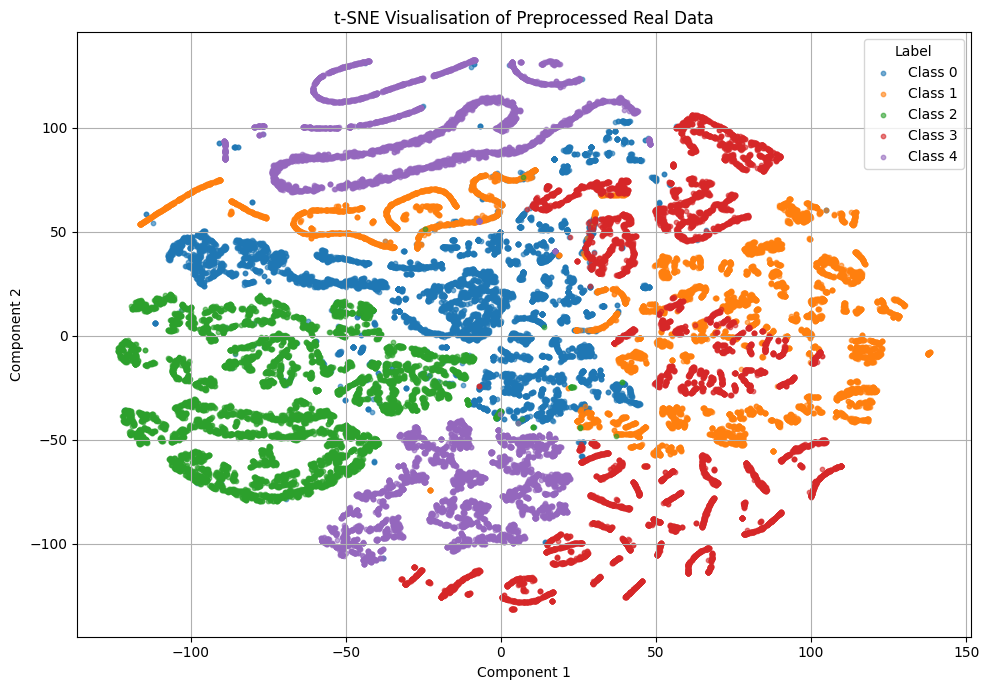

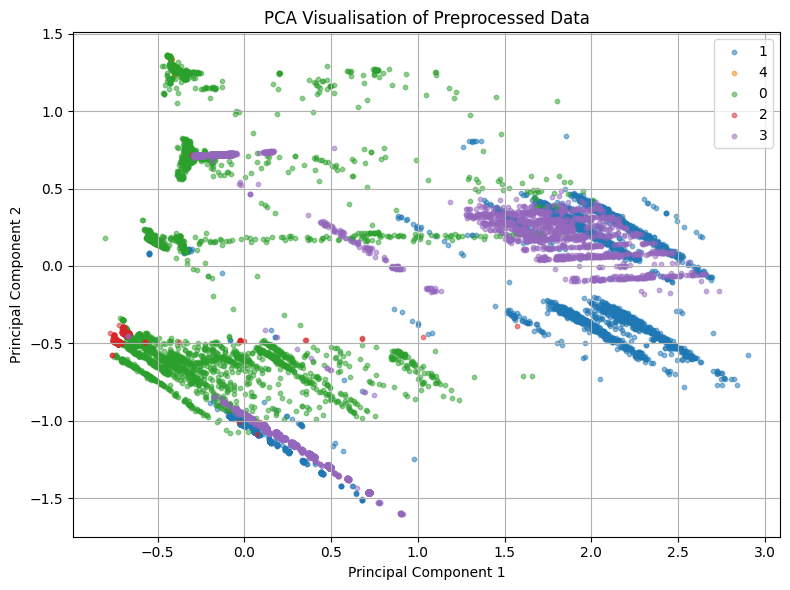

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pandas as pd

# === Load Final Preprocessed Data ===
df = pd.read_csv("/content/drive/MyDrive/CIC-IDS-2017/final_cgan_ready_scaled.csv")

# Separate features and labels
feature_cols = df.columns[df.columns != "Label"]
X = df[feature_cols].values
y = df["Label"].values

# === t-SNE Dimensionality Reduction ===
tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', init='pca', random_state=42)
X_tsne = tsne.fit_transform(X)

# === Plotting ===
plt.figure(figsize=(10, 7))
for label in sorted(df["Label"].unique()):
    indices = y == label
    plt.scatter(X_tsne[indices, 0], X_tsne[indices, 1], label=f"Class {label}", alpha=0.6, s=10)

plt.title("t-SNE Visualisation of Preprocessed Real Data")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(title="Label", loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()


# Only features
X = df[feature_cols]

# Reduce to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Plot by label
plt.figure(figsize=(8, 6))
for label in df['Label'].unique():
    indices = df['Label'] == label
    plt.scatter(X_pca[indices, 0], X_pca[indices, 1], label=label, alpha=0.5, s=10)

plt.title("PCA Visualisation of Preprocessed Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# **GAN Training**

In [ ]:
# === 1. Imports & Device Setup ===
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("📦 Using device:", device)

# === 2. Parameters ===
noise_dim = 100
batch_size = 256
num_epochs = 500
lr = 1e-4
label_smoothing = 0.9

# === 3. Load Data ===
df = pd.read_csv("/content/drive/MyDrive/CIC-IDS-2017/final_cgan_ready_scaled.csv")
X = df.drop("Label", axis=1).values
y = df["Label"].values
num_classes = len(np.unique(y))
feature_dim = X.shape[1]

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)
y_onehot = F.one_hot(y_tensor, num_classes=num_classes).float()

dataloader = DataLoader(TensorDataset(X_tensor, y_tensor), batch_size=batch_size, shuffle=True)

# === 4. Define Generator & Discriminator ===
class Generator(nn.Module):
    def __init__(self, noise_dim, label_dim, output_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim + label_dim, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim),
            nn.Sigmoid()
        )

    def forward(self, noise, labels):
        x = torch.cat((noise, labels), dim=1)
        return self.model(x)


class Discriminator(nn.Module):
    def __init__(self, input_dim, label_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim + label_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, data, labels):
        x = torch.cat((data, labels), dim=1)
        return self.model(x)

# === 5. Initialise Models, Loss, and Optimisers ===
G = Generator(noise_dim, num_classes, feature_dim).to(device)
D = Discriminator(feature_dim, num_classes).to(device)

criterion = nn.BCELoss()
optimizer_G = torch.optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

📦 Using device: cpu


# **Training Loop**

In [ ]:
for epoch in range(1, num_epochs + 1):
    for real_data, labels in dataloader:
        real_data = real_data.to(device)
        labels = labels.to(device)
        batch_size_curr = real_data.size(0)

        real_targets = torch.full((batch_size_curr, 1), label_smoothing, device=device)
        fake_targets = torch.zeros((batch_size_curr, 1), device=device)
        labels_onehot = F.one_hot(labels, num_classes=num_classes).float().to(device)

        # --- Train Discriminator ---
        noise = torch.randn(batch_size_curr, noise_dim, device=device)
        fake_data = G(noise, labels_onehot)
        D_real = D(real_data, labels_onehot)
        D_fake = D(fake_data.detach(), labels_onehot)

        loss_D_real = criterion(D_real, real_targets)
        loss_D_fake = criterion(D_fake, fake_targets)
        loss_D = loss_D_real + loss_D_fake

        optimizer_D.zero_grad()
        loss_D.backward()
        optimizer_D.step()

        # --- Train Generator ---
        noise = torch.randn(batch_size_curr, noise_dim, device=device)
        fake_data = G(noise, labels_onehot)
        D_fake = D(fake_data, labels_onehot)
        loss_G = criterion(D_fake, real_targets)

        optimizer_G.zero_grad()
        loss_G.backward()
        optimizer_G.step()

    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch [{epoch}/{num_epochs}] | D Loss: {loss_D.item():.4f} | G Loss: {loss_G.item():.4f}")

Epoch [1/500] | D Loss: 0.7109 | G Loss: 1.5252
Epoch [10/500] | D Loss: 0.7167 | G Loss: 2.6905
Epoch [20/500] | D Loss: 0.3651 | G Loss: 5.8910
Epoch [30/500] | D Loss: 0.3876 | G Loss: 4.3628
Epoch [40/500] | D Loss: 0.5002 | G Loss: 4.3438
Epoch [50/500] | D Loss: 0.5268 | G Loss: 2.6044
Epoch [60/500] | D Loss: 0.4738 | G Loss: 2.7750
Epoch [70/500] | D Loss: 0.8732 | G Loss: 1.5409
Epoch [80/500] | D Loss: 0.8566 | G Loss: 1.7042
Epoch [90/500] | D Loss: 0.7979 | G Loss: 1.7274
Epoch [100/500] | D Loss: 0.8086 | G Loss: 1.7742
Epoch [110/500] | D Loss: 0.7911 | G Loss: 1.6592
Epoch [120/500] | D Loss: 0.7940 | G Loss: 1.7964
Epoch [130/500] | D Loss: 0.7985 | G Loss: 1.8145
Epoch [140/500] | D Loss: 0.7373 | G Loss: 1.9013
Epoch [150/500] | D Loss: 0.7422 | G Loss: 1.9133
Epoch [160/500] | D Loss: 0.8047 | G Loss: 1.8389
Epoch [170/500] | D Loss: 0.8066 | G Loss: 1.8029
Epoch [180/500] | D Loss: 0.7660 | G Loss: 2.0064
Epoch [190/500] | D Loss: 0.7800 | G Loss: 1.8471
Epoch [200/

🔍 Step 1: Visualising t-SNE & PCA...


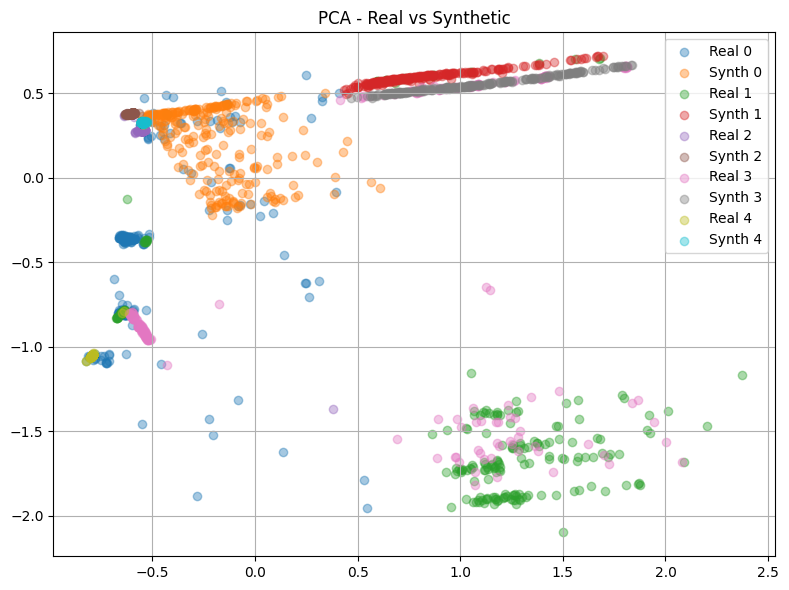

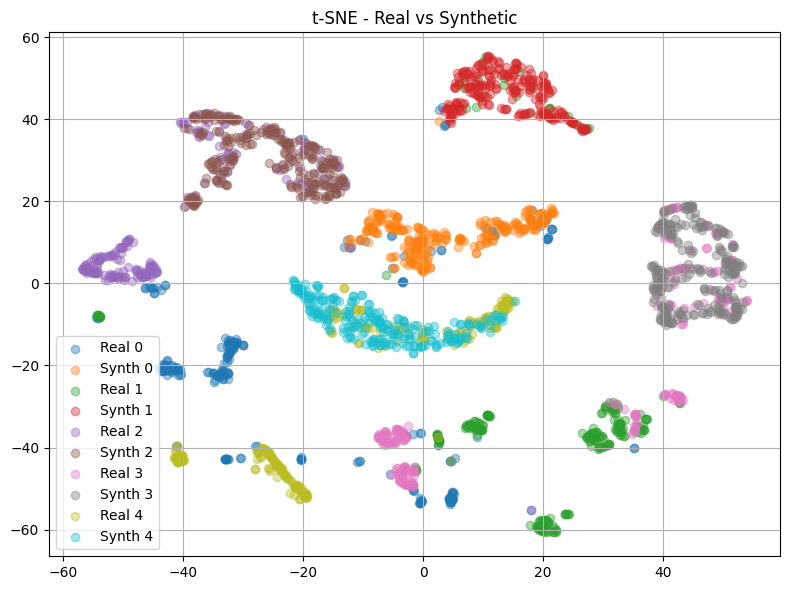

📐 Step 2: Silhouette & μ-distance...
Class 0 → Silhouette: 0.2783 | Δμ: 1.2250
Class 1 → Silhouette: 0.4838 | Δμ: 1.8981
Class 2 → Silhouette: 0.1898 | Δμ: 0.2941
Class 3 → Silhouette: 0.2303 | Δμ: 1.0978
Class 4 → Silhouette: 0.3665 | Δμ: 1.0523
📊 Step 3: F1 Score (Real vs Augmented)...
F1 (Real only):     0.9987
F1 (Real+Synth):    0.9986
🧪 Step 4: Binary Classifier Accuracy...
Binary Classifier Accuracy (Real vs Fake): 0.8343


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, silhouette_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import torch

# === Sampling Function ===
def generate_samples(G, class_id, n_samples=500):
    G.eval()
    z = torch.randn(n_samples, noise_dim, device=device)
    labels = torch.full((n_samples,), class_id, dtype=torch.long, device=device)
    onehot = F.one_hot(labels, num_classes).float()
    with torch.no_grad():
        generated = G(z, onehot).cpu().numpy()
    return generated

# === Extract real data ===
X = df.drop("Label", axis=1).values
y = df["Label"].values
X_real = {i: df[df["Label"] == i].drop("Label", axis=1).values for i in range(num_classes)}

# === 1. PCA & t-SNE Visualisation ===
def visualise_tsne_pca(G):
    samples_synth = np.vstack([generate_samples(G, i, 250) for i in range(num_classes)])
    labels_synth = np.hstack([[i] * 250 for i in range(num_classes)])
    samples_real = np.vstack([X_real[i][:250] for i in range(num_classes)])
    labels_real = np.hstack([[i] * 250 for i in range(num_classes)])

    X_comb = np.vstack([samples_real, samples_synth])
    y_comb = np.hstack([labels_real, labels_synth + num_classes])  # separate classes visually

    for method, name in [(PCA(n_components=2), "PCA"), (TSNE(n_components=2, perplexity=30, random_state=42), "t-SNE")]:
        X_proj = method.fit_transform(X_comb)
        plt.figure(figsize=(8, 6))
        for class_id in np.unique(labels_real):
            plt.scatter(X_proj[y_comb == class_id, 0], X_proj[y_comb == class_id, 1], label=f"Real {class_id}", alpha=0.4)
            plt.scatter(X_proj[y_comb == class_id + num_classes, 0], X_proj[y_comb == class_id + num_classes, 1], label=f"Synth {class_id}", alpha=0.4)
        plt.title(f"{name} - Real vs Synthetic")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# === 2. Silhouette Score and μ-distance ===
def silhouette_and_mu(G):
    for class_id in range(num_classes):
        real = X_real[class_id][:300]
        fake = generate_samples(G, class_id, 300)
        combined = np.vstack([real, fake])
        labels = np.array([0]*len(real) + [1]*len(fake))
        sil_score = silhouette_score(combined, labels)
        mu_distance = np.linalg.norm(real.mean(axis=0) - fake.mean(axis=0))
        print(f"Class {class_id} → Silhouette: {sil_score:.4f} | Δμ: {mu_distance:.4f}")

# === 3. F1 Score Real vs Real+Synth ===
def f1_real_vs_augmented(G):
    clf = RandomForestClassifier()
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

    clf.fit(X_train, y_train)
    f1_real = f1_score(y_test, clf.predict(X_test), average="macro")

    X_synth = np.vstack([generate_samples(G, i, 1000) for i in range(num_classes)])
    y_synth = np.hstack([[i]*1000 for i in range(num_classes)])
    X_train_aug = np.vstack([X_train, X_synth])
    y_train_aug = np.hstack([y_train, y_synth])

    clf_aug = RandomForestClassifier()
    clf_aug.fit(X_train_aug, y_train_aug)
    f1_aug = f1_score(y_test, clf_aug.predict(X_test), average="macro")

    print(f"F1 (Real only):     {f1_real:.4f}")
    print(f"F1 (Real+Synth):    {f1_aug:.4f}")
    return f1_real, f1_aug

# === 4. Binary Real vs Fake Classifier ===
def binary_accuracy(G):
    real = np.vstack([X_real[i][:300] for i in range(num_classes)])
    fake = np.vstack([generate_samples(G, i, 300) for i in range(num_classes)])
    X_comb = np.vstack([real, fake])
    y_comb = np.array([0]*len(real) + [1]*len(fake))

    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_comb, y_comb)
    acc = clf.score(X_comb, y_comb)
    print(f"Binary Classifier Accuracy (Real vs Fake): {acc:.4f}")
    return acc

# === Final Evaluation Runner ===
def run_full_evaluation(G):
    print("🔍 Step 1: Visualising t-SNE & PCA...")
    visualise_tsne_pca(G)

    print("📐 Step 2: Silhouette & μ-distance...")
    silhouette_and_mu(G)

    print("📊 Step 3: F1 Score (Real vs Augmented)...")
    f1_real, f1_aug = f1_real_vs_augmented(G)

    print("🧪 Step 4: Binary Classifier Accuracy...")
    acc_bin = binary_accuracy(G)

    return {
        "F1_Real": round(f1_real, 4),
        "F1_Augmented": round(f1_aug, 4),
        "Binary_Accuracy": round(acc_bin, 4)
    }

# === Run Evaluation ===
results = run_full_evaluation(G)

**Save Trained Models**

NameError: name 'D' is not defined

In [ ]:
import torch

# Paths to save the models
G_path = "/content/drive/MyDrive/CIC-IDS-2017/models/attempt1_generator.pth"
D_path = "/content/drive/MyDrive/CIC-IDS-2017/models/attempt1_discriminator.pth"

# Create the directory if it doesn't exist
import os
os.makedirs(os.path.dirname(G_path), exist_ok=True)

# Save the model weights
torch.save(G.state_dict(), G_path)
torch.save(D.state_dict(), D_path)

print("✅ Models saved successfully.")

✅ Models saved successfully.


**Load Saved Models Later**

In [ ]:
# Re-create the Generator and Discriminator with same architecture
G = Generator(noise_dim, num_classes, feature_dim).to(device)
D = Discriminator(feature_dim, num_classes).to(device)

# Load the weights
G.load_state_dict(torch.load(G_path, map_location=device))
D.load_state_dict(torch.load(D_path, map_location=device))

G.eval()
D.eval()

print("✅ Models loaded successfully.")


In [ ]:
# === 1. Redefine Generator & Discriminator classes ===
import torch.nn as nn
import pandas as pd
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

df = pd.read_csv("/content/drive/MyDrive/CIC-IDS-2017/final_cgan_ready_scaled.csv")
feature_dim = df.drop("Label", axis=1).shape[1]


class Generator(nn.Module):
    def __init__(self, noise_dim, label_dim, output_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim + label_dim, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim),
            nn.Sigmoid()
        )

    def forward(self, noise, labels):
        x = torch.cat((noise, labels), dim=1)
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, input_dim, label_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim + label_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, data, labels):
        x = torch.cat((data, labels), dim=1)
        return self.model(x)

# === 2. Define necessary variables (if not already defined) ===
noise_dim = 100  # Or whatever value you used during training
num_classes = 5
# === 2. Parameters ===
  # Number of classes in your dataset
#Assuming 'df' is available, you can get feature_dim:
# feature_dim = df.drop("Label", axis=1).shape[1]
#Otherwise, use the value from training

# === 3. Re-initialise models ===
G_loaded = Generator(noise_dim, num_classes, feature_dim).to(device)
D_loaded = Discriminator(feature_dim, num_classes).to(device)

# === 4. Load the weights ===
G_path = "/content/drive/MyDrive/CIC-IDS-2017/models/attempt1_generator.pth"
D_path = "/content/drive/MyDrive/CIC-IDS-2017/models/attempt1_discriminator.pth"

G_loaded.load_state_dict(torch.load(G_path, map_location=device))
D_loaded.load_state_dict(torch.load(D_path, map_location=device))

G_loaded.eval()
D_loaded.eval()

print("✅ Generator & Discriminator successfully loaded!")

✅ Generator & Discriminator successfully loaded!


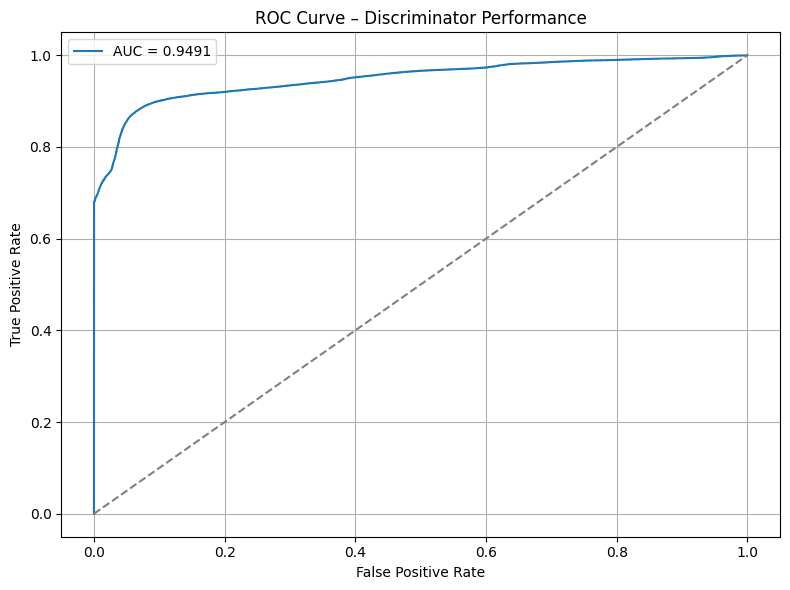

📈 AUC Score: 0.9491


In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

# === Simulate evaluation ===
def evaluate_auc_roc(D, G, X_real, y_real, noise_dim, num_classes, device='cuda'):
    D.eval()
    G.eval()

    # Convert real data to tensor
    X_real_tensor = torch.tensor(X_real, dtype=torch.float32, device=device)
    y_tensor = torch.tensor(y_real, dtype=torch.long, device=device)
    y_onehot = F.one_hot(y_tensor, num_classes=num_classes).float().to(device)

    # Generate synthetic data with same labels
    z = torch.randn(len(X_real), noise_dim, device=device)
    X_fake_tensor = G(z, y_onehot)

    # Discriminator outputs
    with torch.no_grad():
        D_real = D(X_real_tensor, y_onehot).cpu().numpy().flatten()
        D_fake = D(X_fake_tensor, y_onehot).cpu().numpy().flatten()

    # Labels: 1 for real, 0 for fake
    y_true = np.concatenate([np.ones_like(D_real), np.zeros_like(D_fake)])
    y_scores = np.concatenate([D_real, D_fake])

    # Compute AUC
    auc = roc_auc_score(y_true, y_scores)

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
    plt.plot([0, 1], [0, 1], linestyle="--", color="grey")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve – Discriminator Performance")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return auc

df = pd.read_csv("/content/drive/MyDrive/CIC-IDS-2017/final_cgan_ready_scaled.csv")
X_real = df.drop("Label", axis=1).values
y_real = df["Label"].values

# Evaluate AUC/ROC
auc = evaluate_auc_roc(D_loaded, G_loaded, X_real, y_real, noise_dim, num_classes, device=device)
print(f"📈 AUC Score: {auc:.4f}")
